In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/5013 - Project/m5-forecasting-uncertainty

/content/drive/.shortcut-targets-by-id/129se4YWr7uxgjWW5UxAKQMxQvb6wH99Q/5013 - Project/m5-forecasting-uncertainty


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc

In [4]:
def get_cat(inp):
    tokens = inp.split("_")
    return tokens[0]

In [5]:
def get_dept(inp):
    tokens = inp.split("_")
    return tokens[0] + "_" + tokens[1]

In [6]:
l12 = pd.read_csv("./data/sales_train_evaluation.csv")
l12.id = l12.id.str.replace('_evaluation', '')

In [7]:
l12.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
30485,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0
30489,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,2,0,5,4,0,2,2,5,1


In [8]:
COLS = [f"d_{i+1}" for i in range(1941)]

In [9]:
%%time
print("State & Item")
l11 = l12.groupby(['state_id','item_id']).sum().reset_index()
l11["store_id"] = l11["state_id"]
l11["cat_id"] = l11["item_id"].apply(get_cat)
l11["dept_id"] = l11["item_id"].apply(get_dept)
l11["id"] = l11["state_id"] + "_" + l11["item_id"]

print("Item")
l10 = l12.groupby('item_id').sum().reset_index()
l10['id'] = l10['item_id'] + '_X'
l10["cat_id"] = l10["item_id"].apply(get_cat)
l10["dept_id"] = l10["item_id"].apply(get_dept)
l10["store_id"] = 'X'
l10["state_id"] = 'X'

print("Store & Dept")
l9 = l12.groupby(['store_id','dept_id']).sum().reset_index()
l9["cat_id"] = l9["dept_id"].apply(get_cat)
l9["state_id"] = l9["store_id"].apply(get_cat)
l9["item_id"] = l9["dept_id"]
l9["id"] = l9["store_id"] + '_' + l9["dept_id"]

print("Store & Cat")
l8 = l12.groupby(['store_id','cat_id']).sum().reset_index()
l8['dept_id'] = l8['cat_id']
l8['item_id'] = l8['cat_id']
l8['state_id'] = l8['store_id'].apply(get_cat)
l8["id"] = l8["store_id"] + '_' + l8["cat_id"]

print("State & Dept")
l7 = l12.groupby(['state_id','dept_id']).sum().reset_index()
l7["store_id"] = l7["state_id"]
l7["cat_id"] = l7["dept_id"].apply(get_cat)
l7["item_id"] = l7["dept_id"]
l7["id"] = l7["state_id"] + '_' + l7["dept_id"]

print("State & Cat")
l6 = l12.groupby(['state_id','cat_id']).sum().reset_index()
l6["store_id"] = l6["state_id"]
l6["dept_id"] = l6["cat_id"]
l6["item_id"] = l6["cat_id"]
l6["id"] = l6["state_id"] + "_" + l6["cat_id"]

print("Dept")
l5 = l12.groupby('dept_id').sum().reset_index()
l5["cat_id"] = l5["dept_id"].apply(get_cat)
l5["item_id"] = l5["dept_id"]
l5["state_id"] = "X"
l5["store_id"] = "X"
l5["id"] = l5["dept_id"] + "_X"

print("Cat")
l4 = l12.groupby('cat_id').sum().reset_index()
l4["store_id"] = l4["cat_id"]
l4["item_id"] = l4["cat_id"]
l4["store_id"] = "X"
l4["state_id"] = "X"
l4["id"] = l4["cat_id"] + "_X"

print("Store")
l3 = l12.groupby('store_id').sum().reset_index()
l3["state_id"] = l3["store_id"].apply(get_cat)
l3["cat_id"] = "X"
l3["dept_id"] = "X"
l3["item_id"] = "X"
l3["id"] = l3["store_id"] + "_X"

print("State")
l2 = l12.groupby('state_id').sum().reset_index()
l2["store_id"] = l2["state_id"]
l2["cat_id"] = "X"
l2["dept_id"] = "X"
l2["item_id"] = "X"
l2["id"] = l2["state_id"] + "_X"

print("Total")
l1 = l12[COLS].sum(axis=0).values
l1 = pd.DataFrame(l1).T
l1.columns = COLS
l1["id"] = 'Total_X'
l1['state_id'] = 'X'
l1['store_id'] = 'X'
l1['cat_id'] = 'X'
l1['dept_id'] = 'X'
l1['item_id'] = 'X'

State & Item
Item
Store & Dept
Store & Cat
State & Dept
State & Cat
Dept
Cat
Store
State
Total
CPU times: user 8.43 s, sys: 834 ms, total: 9.26 s
Wall time: 11.9 s


In [10]:
df = pd.DataFrame()
df = df.append([l12, l11, l10, l9, l8, l7, l6, l5, l4, l3, l2, l1])

In [11]:
df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
9,WI_3_X,X,X,X,WI_3,WI,4038,4198,3317,3211,...,3987,5674,5894,3897,3306,3268,3398,4126,4519,4757
0,CA_X,X,X,X,CA,CA,14195,13805,10108,11047,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
1,TX_X,X,X,X,TX,TX,9438,9630,6778,7381,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
2,WI_X,X,X,X,WI,WI,8998,8314,6897,6984,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879
0,Total_X,X,X,X,X,X,32631,31749,23783,25412,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


In [12]:
sub = pd.read_csv("./data/sample_submission.csv")
sub['id'] = sub.id.str.replace('_evaluation', '')
grps =sub.iloc[-42840:, 0].unique()
grps = [col.replace("_0.995","") for col in grps]

In [13]:
for col in ['id','item_id','dept_id','cat_id','store_id','state_id']:
    print(col, df[col].nunique())

id 42840
item_id 3060
dept_id 11
cat_id 4
store_id 14
state_id 4


In [14]:
X = df[COLS].values
x = (X>0).cumsum(1)
x = x>0
st = x.argmax(1)
den = 1941 - st - 2
diff = np.abs(X[:,1:] - X[:,:-1])
norm = diff.sum(1) / den

In [15]:
df["start"] = st
df["scale"] = norm

In [16]:
df.tail(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,start,scale
9,WI_3_X,X,X,X,WI_3,WI,4038,4198,3317,3211,...,5894,3897,3306,3268,3398,4126,4519,4757,0,538.851470
0,CA_X,X,X,X,CA,CA,14195,13805,10108,11047,...,24704,17721,16150,15678,16297,17430,23103,24644,0,1970.131511
1,TX_X,X,X,X,TX,TX,9438,9630,6778,7381,...,16249,12228,11370,10375,9162,12303,13681,14815,0,1349.161939
2,WI_X,X,X,X,WI,WI,8998,8314,6897,6984,...,18968,12413,11257,11043,11504,12819,14734,14879,0,1440.429603
0,Total_X,X,X,X,X,X,32631,31749,23783,25412,...,59921,42362,38777,37096,36963,42552,51518,54338,0,4280.873130


In [17]:
df.shape

(42840, 1949)

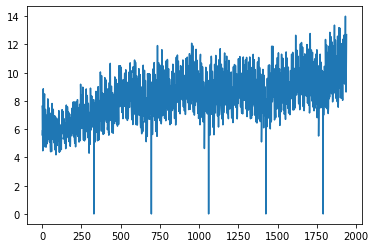

In [18]:
plt.plot(X[-1]/norm[-1])
plt.show()

In [19]:
df.to_csv("./data/sales.csv", index=False)